# Computational Methods in Economics

## Lecture 5 - Numerical Optimization

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2017-12-06 07:57:43.230234


### Preliminaries

#### Import Modules

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

import scipy.optimize

import statsmodels.api as sm

## This Lecture

- [Introduction](#introduction)
- [Golden Search](#golden)
- [Nelder-Mead (Simplex)](#Nelder-Mead)
- [Overview: Line Search](#overview)
- [The Newton-Raphson Method](#newton)
- [Gradient Descent](#gradient)
- [Quasi-Newton Methods: BFGS](#quasi)
- [Example: Solving the NGM](#NGM)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'introduction'></a>

## Introduction

Optimization (minimization or maximization) is at the heart of almost all economic models, which makes numerical algorithms for optimization an essential part of an economist's computational toolbox. Before talking about these algorithms in detail, we start with a short refresher on the theory behind optimization.

### Review: Unconstrained Optimization

Unconstrained optimization entails *minimizing* an (scalar) *objective function* $f: \mathbb{R}^n \rightarrow \mathbb{R}$:

\begin{equation}
    \min_{x} f(x)
\end{equation}

with
\begin{equation}
    x \in \mathbb{R}^n
\end{equation}
and $f$ being a smooth function.

Note that we frame the problem here in terms of minimization, mainly because that's how the Scipy implementations that we will see do it. *Maximizing* a function is equivalent to minimizing its negative.

Usually, we want to find a *global* minimum and hence a *global minimizer* of $f$. Formally, a global minimizer for the problem above is a point $x^*$ if $f(x^*) \le f(x)$ for all $x$ in the relevant domain. 

However, most algorithms developed for numerical optimization (and in fact all algorithms discussed in this class) aim to find a local optimum, and hence a *local minimizer*. A local minimizer is a point $x^*$ if there is a neighborhood $\mathcal{N}$ of $x^*$ such that $f(x^*) \le f(x)$ for all $x$ in $\mathcal{N}$. For a *strict* or *strong* local minimizer, the inequality is strict. If $x^*$ is the only local minimizer in $\mathcal{N}$, it is also called an *isolated* minimizer. All isolated local minimizers are strict, however strict minimizers are not always isolated.

Why do the methods below focus on local minimizers? The more points an algorithm has to "visit" (i.e. evaluate the function), the more computer time and/or storage it needs, which we aim to keep as small as possible. To find a global minimizer, we would need to sample points over the whole relevant domain of $f$. However, note if we know that a function is *convex*, a local minimizer is also a global minimizer. 

How do we recognize a local minimum? We rely on the following necessary and sufficient conditions (that you have probably used in almost every economics class you've ever taken):
- If $x^*$ is a local minimizer of $f$ and $f$ is continuously differentiable in an open neighborhood around $x^*$, then the *gradient* $\nabla f(x^*)$ is zero. For a univariate function, $f'(x^*) = 0$.
- If $x^*$ is a local minimizer and $\nabla^2 f$ exists and is continuous in an open neighborhood around $x^*$, then $\nabla f(x^*) = 0$ and $\nabla^2 f(x^*)$ is positive semidefinite.
- Suppose that $\nabla^2 f$ is continuous in an open neighborhood around $x^*$ and that $\nabla f(x^*) = 0$ and $\nabla^2 f(x^*)$ is positive semidefinite. Then $x^*$ is a strict local minimizer of $f$.

Recall that a square matrix $A$ of order $n$ is *positive definite* if there is a positive scalar such that

\begin{equation}
    x^T A x \ge \alpha x^T x \quad \text{for all} \quad x \in \mathbb{R}^n
\end{equation}

It is *positive semidefinite* if 

\begin{equation}
    x^T A x \ge 0 \quad\text{for all} \quad x \in \mathbb{R}^n
\end{equation}

For a univariate function, a positive semidefinite Hessian just means that the second derivative of the function is positive. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'golden'></a>

## Golden Search

Similar to root finding, for performing numerical optimization we have both derivative-free methods as well as algorithms that either rely on analytical derivatives provided by the user or approximate the derivatives numerically. First, we look at an important method for maximizing a *univariate* function without using derivates, namely *golden (section) search*.

Conceptually, golden search is similar to bisection: we bracket the minimum $x^*$ by the interval $[a, b]$ and then sequentially reduce the length of the interval. One important difference to bisection is that we need to evaluate the function at *two* points inside the bracket, rather than one as in the case of bisection.  

![gs.png](attachment:gs.png)

In [3]:
## cp. figure in class
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

The obvious question is then how to choose the *search points* $c$ and $d$ inside the bracket. Golden search prescribes the following rule:

\begin{align}
    c &= a + r (b - a) \\
    d &= b - r (b - a)
\end{align}

where

\begin{equation}
    r = \frac{3 - \sqrt{5}}{2} \approx 0.382...
\end{equation}    

This satisfies two criteria:

- The new interval always has the same length, independent on whether the upper or lower bound is replaced:

\begin{equation}
       b - c = d - a = (1 - r)(b - a) 
\end{equation}   

- For every refinement after the first, one of the search points equals the search point from the previous refinement that was not used as a new bound; in other words,

    1. if $f(c) < f(d)$, the new interval is $[a, d]$; for the next refinement, $d' = c$
    2. if $f(c) > f(d)$, the new interval is $[c, b]$; for the next refinement, $c' = d$

This has the advantage that only one function evaluation is performed per iteration; e.g. in the first case, we need to evaluate $f(c')$, but we already have evaluated $f(d') = f(c)$ for the previous refinement. 

In Python, golden section search for minimizing a univariate function is implemented in **scipy.optimize.golden**. Below, we apply it on the function $f(x) = - \exp(-x) \sin(x)$:

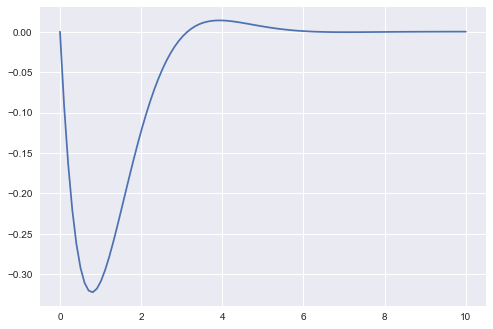

In [4]:
f = lambda x: -np.exp(-x) * np.sin(x)
x = np.linspace(0, 10, 100)
plt.plot(x, f(x))

In [5]:
scipy.optimize.golden(f, brack = (0, 2))

0.7853981651501754

We will not use golden search very often, for the simple reason that we usually optimize over functions with more than one variable. However, golden search is useful in the case of univariate functions with derivatives that are irregular or computationally costly to evaluate.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'Nelder-Mead'></a>

## Nelder-Mead (Simplex)

Compare http://www.benfrederickson.com/numerical-optimization/ for a visualization.

#### Example: "Banana" function

The *Rosenbrock function* (also called *Rosenbrock's banana function*) is often used to test the performance of optimization algorithms. In its simplest form with two variables, it looks like the following:

\begin{equation}
    f(x, y) = (a - x)^2 + b (y - x^2)^2
\end{equation}

Its global minimum is at $(a, a^2)$. Below, we set $a = 1$ and $b = 100$.

In [6]:
def banana(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

Plotting the banana function with a contour plot shows the "Rosenbrock valley" that contains the smallest function values, including the minimum:

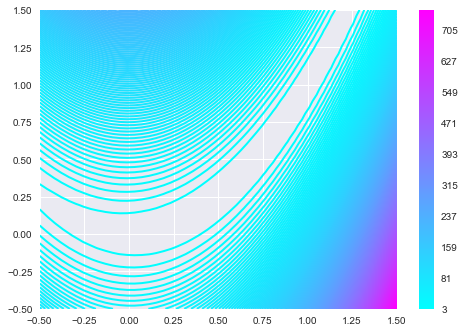

In [7]:
x = np.linspace(-0.5, 1.5, 50)
y = np.linspace(-0.5, 1.5, 50)
xx, yy = np.meshgrid(x, y)
z = banana(xx, yy)

## plot contour
fig, ax = plt.subplots()
CP = ax.contour(x, y, z, 300,  linewidths=2, cmap='cool')
fig.colorbar(CP)

Scipy has an implementation of the Rosenbrock function, including its gradient and Hessian, as **scipy.optimize.rosen**, **scipy.optimize.rosen_der** and **scipy.optimize.rosen_hess**, respectively. 

In order to solve it with Nelder-Mead, we can use Scipy's **minimize** function, which is a "wrapper" around several different methods (some of them also for constrained optimization). Compare the documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html.

The default arguments to be given to **minimize** are the name of the function, an initial guess and the name of the method.

In [8]:
scipy.optimize.minimize(scipy.optimize.rosen, [1.5, 2], method = 'Nelder-Mead')

 final_simplex: (array([[ 0.99998287,  0.99996782],
       [ 1.00002868,  1.00005929],
       [ 0.99996631,  0.99992986]]), array([  7.23522566e-10,   1.19247963e-09,   1.89213626e-09]))
           fun: 7.2352256587046537e-10
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 49
        status: 0
       success: True
             x: array([ 0.99998287,  0.99996782])

More generally, Rosenbrock's function can be defined for $N \ge 2$ variables:

\begin{equation}
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N
\end{equation}

When minimizing the function, we can indicate the dimension of $\mathbf{x}$ by the length of the array serving as the initial guess: 

In [9]:
scipy.optimize.minimize(scipy.optimize.rosen, [1.5, 2, 2, 2, 2], method = 'Nelder-Mead')

 final_simplex: (array([[ 1.00000342,  1.00000518,  1.00001268,  1.0000237 ,  1.00004644],
       [ 1.00000518,  1.00001424,  1.00002928,  1.00005383,  1.00010782],
       [ 0.99999397,  0.99999598,  0.9999898 ,  0.9999779 ,  0.99995271],
       [ 1.00000253,  1.00001166,  1.00002235,  1.0000485 ,  1.00010125],
       [ 1.00000527,  1.00000843,  1.00001001,  1.00001619,  1.00003999],
       [ 1.00000403,  1.000006  ,  1.00000274,  1.00000851,  1.00001169]]), array([  1.93938932e-09,   7.79562146e-09,   8.82573360e-09,
         1.06950989e-08,   1.28607339e-08,   1.29121498e-08]))
           fun: 1.9393893195016722e-09
       message: 'Optimization terminated successfully.'
          nfev: 653
           nit: 407
        status: 0
       success: True
             x: array([ 1.00000342,  1.00000518,  1.00001268,  1.0000237 ,  1.00004644])

Similar to golden search in the univariate case, use the Nelder-Mead algorithm only in cases where a single optimization is performed and evaluating the function and its derivatives is costly. Nelder-Mead is slow and unreliable, in particular for problems with more than two dimensions. In those cases, we are better off with using a variant of *line search*.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'overview'></a>

## Overview: Line Search

*Line search methods* are one of the two fundamental approaches to (unconstrained) optimization (*trust region methods* being the other), and the one which we focus on in this course. 

Line search is an iterative procedure, generating a sequence of iterates $\{ x^{(k)} \}$ that are aimed to converge towards the minimum $x^*$. When moving from one iterate to the next, two variables are essential: the *search direction*, denoted by $p^{(k)}$, i.e. the direction in which to move from $x^{(k)}$, and the *distance* $\alpha^{(k)}$, i.e. the length of the *step* $s^{(k)}$ from $x^{(k)}$ to $x^{(k+1)}$ along $p^{(k)}$.

On a general level, line search algorithms take the direction $p^{(k)}$ as given and then solve the following problem:

\begin{equation}
    \min_{\alpha > 0} f(x^{(k)} + \alpha p^{(k)})
\end{equation}

and then set 

\begin{equation}
    x^{(k+1)} = x^{(k)} + s^{(k)} = x^{(k)} + \alpha^{(k)} p^{(k)}
\end{equation}

Different variants of line search methods differ in their choice of the search direction $p^{(k)}$ (and some also fix $\alpha$), as we will see below. Before, we consider a simple economic application that will serve as a workhorse example for the rest of this lecture. 


### Example: Monopoly 

This example is taken from Judd (1998), p. 105 f. Suppose a firm produces two products, $Y$ and $Z$. The demand for them can be derived from the household's utility function

\begin{equation}
U(Y, Z) = u(Y, Z) + M = (Y^\alpha + Z^\alpha)^{\frac{\eta}{\alpha}},
\end{equation}

where $M$ denotes expenditures on other goods. Solving the household problem, we get $p_j = u_j(Y, Z)$. If the firm acts a monopolist, it takes into account how prices depend on the supply of $Y$ and $Z$. Hence, its profit maximization problem can be written as:

\begin{equation}
    \max_{Y, Z} \Pi(Y, Z) = u_Y(Y, Z) Y + u_Z(Y, Z) Z - c_y Y - c_z Z,
\end{equation}

where we assume that the marginal cost of producing $Y$ and $Z$ are constant and given by $c_Y$ and $c_Z$, respectively.

The following piece of code determines the parameter values and defines the cost and utility functions, including a function computing the derivatives of $u$.

In [10]:
### functions and parameters
alpha = 0.98
eta = 0.85

cy = 0.62
cz = 0.6

Cy = lambda x : cy * x
Cz = lambda x : cz * x

def u(Y, Z):
    return (Y**alpha + Z**alpha)**(eta/alpha)

def ud(Y, Z):
    return eta * (Y**alpha + Z**alpha)**(eta/alpha - 1) * Y**(alpha - 1)

One issue when using unconstrained optimization for economic problems is that many variables are bound to be nonnegative. In the example here, $Y$ and $Z$ represent quantities of goods, and hence, by definition, cannot be negative. However, the algorithms presented below may "visit" negative values for these decision variables. A common "trick" to deal with this is to restate the problem in terms of $\ln(Y) \equiv y$ and $\ln(Z) \equiv z$. In this way, while $y$ and $z$ can take any values, $Y = \exp(y)$ and $Z = \exp(z)$ are guaranteed to be positive.

Hence, the objective function can be coded up in the following way:

In [11]:
def obj(x):
    """
    Implements the objective function (here profit) for the monopoly example: Y * ud(Y, Z) + Z * ud(Z, Y) - Cy(Y) - Cz(Z)
    """
    Y = np.exp(x[0])
    Z = np.exp(x[1])
    
    return - (Y * ud(Y, Z) + Z * ud(Z, Y) - Cy(Y) - Cz(Z))

As mentioned above, different variants of the line search method differ among each other with respect to their choice of the step size and direction, and hence with respect to how to determine $s^{(k)} = \alpha^{(k)} p^{(k)}$. Other than this, they all follow the same (by now well-known) iterative procedure that is implemented in the function **my_opt**.

In [12]:
def my_opt(x, obj, step, maxit = 100, eps = 1e-8, delta = 1e-4):
    """
    Implements the iterative procedure for all of the optimization algorithms considered below. Inputs are 
    -> x: initial guess for the minimizing vector
    -> obj: objective, defined a function of x
    -> step: a function implementing how the step from x(k) to x(k+1) is determined
    """
    dist = 1
    it = 0
    
    lx = []
    while dist > eps and it < maxit:
        lx.append(x)
        it += 1
    
        s, alpha = step(x, obj)
    
        dist = np.linalg.norm(s) / (1 + np.linalg.norm(x))
        print(it, dist, alpha)
        x = x + s
    
    ## check for optimality
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    if np.linalg.norm(gr) > delta * (1 + abs(obj(x))):
        print('Solution does not appear an optimum!')
    
    return x, lx           

Note the following:

- **my_opt** takes an "update rule" (a function) **step** as an argument, which returns $s^{(k)}$, as well as $\alpha^{(k)}$. The implementation of **step** depends on the specific algorithm, as outlined below.

- As with rootfinding, we use a "twofold" convergence test: first we determine if the sequence has converged, and then we check whether we have achieved optimality (i.e. whether $\nabla f( x^{(k)})$ is close to zero). For the first test, we use the relative distance between the current and the updated $x$  as a stopping criterion, which can be written as

\begin{equation}
    \frac{ || s^{(k)} || }{1 + || x^{(k)} ||} \le \epsilon 
\end{equation}

As before, a good rule of thumb for the value of $\epsilon$ is the square root of machine epsilon.  

- The optimality test checks whether $\left| \left |\ \nabla f( x^{(k)}) \right| \right| < \delta(1 + \left|\ f(x^{(k)}) \right|$. This test is typically passed for most objective functions that we encounter and hence "optional". Note that above we use a numerical approximation to the gradient. In this case, $\delta$ should not be set too low.

- For illustration, we print the iteration counter, the distance and the value for $\alpha^{(k)}$ in every iteration. We also store the values for $x^{(k)}$ in a list **lx**. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'newton'></a>

## Newton-Raphson

Recall that in the context of root finding in the previous lecture, Newton's method used an iteration rule based on taking a first-order Taylor approximation of the function of interest and setting it to zero. Similarly, Newton's method in the context of optimization, also called the *Newton-Raphson method*, requires a second-order Taylor approximation to $f$, which is then minimized. 

Recall that for a multivariate function $f: \mathbb{R}^n\ \rightarrow \mathbb{R}$, a second-order Taylor approximation of $f(\mathbf{x})$ around $x_0$ is given by:

\begin{equation}
    f(\mathbf{x}) \approx f(\mathbf{x}_0) + \nabla f(\mathbf{x}_0)^{T} (\mathbf{x} - \mathbf{x}_0) + \frac{1}{2} (\mathbf{x} - \mathbf{x}_0)^T \nabla^2 f(\mathbf{x}_0) (\mathbf{x} - \mathbf{x}_0)
\end{equation}

Minimizing $f$ implies taking the derivative with respect to $\mathbf{x}$ and setting it equal to zero:

\begin{equation}
    \nabla f(\mathbf{x}) \approx \nabla f(\mathbf{x}_0) + \nabla^2 f(\mathbf{x}_0) (\mathbf{x} - \mathbf{x}_0) = 0
\end{equation}

As in the case of root finding, we can derive an iteration rule by noting that

\begin{equation}
 \mathbf{x} = \mathbf{x}_0 - [\nabla^2 f(\mathbf{x}_0)]^{-1} \nabla f(\mathbf{x}_0)
\end{equation}

For notational convenience, I define $H(\mathbf{x}_0) = \nabla^2 f(\mathbf{x}_0)$ for the Hessian. For the following,  we implicitly assume here that $H(\cdot)$ is positive definite (recall the necessary conditions for a minimum above). We will get back to this later. 

Hence, the key idea is to use this relation iteratively, i.e. generate a sequence $\mathbf{x}^{(1)}, \mathbf{x}^{(2)}, ..., \mathbf{x}^{(m)}$ where

\begin{equation}
 \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - H(\mathbf{x}^{(k)}) ^{-1}\nabla  f(\mathbf{x}^{(k)}) = \mathbf{x}^{(k)} + s^{(k)}
\end{equation}

Recall that in the context of root finding, Newton's method relies on successive linearization, i.e. generates a sequence of points, each of which is a root to a linear local approximation to the function of interest. Similarly, at each iteration Newton-Raphson replaces the function $f$ with a *quadratic* local approximation based on $\mathbf{x}^{(k)}$ and chooses the minimum of this approximation as the next point $\mathbf{x}^{(k+1)}$.

The Newton-Raphson method implements the following pseudo-code:

(i) Choose an initial guess $x^{(0)}$ and tolerance levels/stopping criteria $\epsilon$ and $\delta$. 

(ii) Compute the gradient $\nabla  f(x^{(k)})$ and the Hessian $H(x^{(k)})$ at $x^{(k)}$ (using either analytical derivatives or numerical differentiation).

(iii) Solve $H(x^{(k)})s^{(k)} = - \nabla f(x^{(k)})$, and set $ x^{(k+1)} = x^{(k)} + s^{(k)} $.

(iv) Check the stopping rule: if $\left| \left |\ x^{(k+1)}- x^{(k)} \right| \right| < \epsilon\left(1 + \left| \left |\ x^{(k)} \right| \right|\right)$, stop. If not, go back to (ii).

(v) Check for optimality: if $\left| \left |\ \nabla f( x^{(k)}) \right| \right| < \delta(1 + \left|\ f(x^{(k)}) \right|$, report $x^{(k)}$ as the solution. Otherwise, report failure.

In the context of root finding, we stated that Newton's method converges *quadratically*. The same is true for the Newton-Raphson method, as long as we are sufficiently close to the solution. This is summarized in the following theorem: Suppose that $f(x)$ is thrice continuously differentiable, minimized at $x^*$ and that $H(x^*)$ is non-singular. Then there is some $\epsilon > 0$ such that if $\left| \left|\ x^{(0)} - x^* \right| \right| < \epsilon$, then the sequence $\{ x^{(k)} \}$ converges quadratically to $x^*$.

Below, we use the Newton-Raphson method to solve the monopoly example outlined above. Recall that we just have to provide a rule on how the step $s^{(k)}$ from $x^{(k)}$ to  $x^{(k+1)}$ is computed. This is implemented by the function **newton**. Note that instead of computing the gradient and the Hessian of the objective function analytically, we use the numerical approximations provided by statsmodels' **tools.numdiff** package, as shown in the previous lecture. 

In [13]:
def newton(x, obj):
    """
    Implements the Newton-Raphson update rule, using numerical differentiation
    """
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    H = sm.tools.numdiff.approx_hess3(x, obj)
    
    return ( scipy.linalg.solve(H, -gr), 1 )

Solving for the monopoly allocation then requires calling the function **my_opt** defined above, providing a starting value for $x$, the objective function and the function **newton** as the update rule.

In [14]:
x0 = np.array([1.5, 2])
x, lx = my_opt(x0, obj, newton)
## print equilibrium -> recall that the model is solved for log quantities!
print("Equilibrium quantities: {}".format(np.exp(x)))

1 0.235533360122 1
2 0.223777180408 1
3 0.177100606851 1
4 0.174697873963 1
5 0.099282939784 1
6 0.0317292921423 1
7 0.00309802766798 1
8 3.02837502187e-05 1
9 0.0 1
Equilibrium quantities: [ 0.56975348  2.93569797]


In [15]:
%%timeit -n1 -r1
my_opt(x0, obj, newton)

1 0.235533360122 1
2 0.223777180408 1
3 0.177100606851 1
4 0.174697873963 1
5 0.099282939784 1
6 0.0317292921423 1
7 0.00309802766798 1
8 3.02837502187e-05 1
9 0.0 1
1 loop, best of 1: 24 ms per loop


To illustrate quadratic convergence, compare the distance from $x^{(k)}$ to $x^*$:

In [16]:
print(x - lx)

[[ -2.06255150e+00  -9.23054767e-01]
 [ -1.45497919e+00  -3.65886535e-01]
 [ -9.77389529e-01   2.92808168e-03]
 [ -6.13433526e-01   1.15626512e-01]
 [ -2.78783937e-01   4.09823822e-02]
 [ -7.53160637e-02   9.26494234e-03]
 [ -6.87348081e-03   7.77553897e-04]
 [ -6.66382154e-05   7.66846341e-06]
 [  0.00000000e+00   0.00000000e+00]]


We also apply our **newton** function to Rosenbrock's function described above. Recall that for $N = 5$, the Nelder-Mead simplex algorithm required about 400 iterations to get to a solution. We see that Newton-Raphson is consideraby faster:

In [17]:
x0 = np.array([1.5, 2, 2, 2, 2])
x, lx = my_opt(x0, scipy.optimize.rosen, newton)
print("Solution: {}".format(x))

1 0.482154559456 1
2 0.352957781849 1
3 0.0167370383758 1
4 0.864255670733 1
5 0.596342662577 1
6 0.0937877305753 1
7 0.0121842608745 1
8 0.040021567081 1
9 0.00122491248685 1
10 0.000949594708877 1
11 5.41022869788e-07 1
12 2.53024373024e-10 1
Solution: [ 0.9999992   0.99999841  0.99999684  0.99999368  0.99998736]


Since Scipy has functions containing the (analytical) gradient and Hessian of the Rosenbrock function, we can use them to compare how well the numerical approximations to gradient and Hessian in our **newton** function perform. We do not see any qualitative difference.

In [18]:
def newton_rb(x, obj):
    """
    Implements the Newton-Raphson update rule for the Rosenbrock function
    """
    gr = scipy.optimize.rosen_der(x)
    H = scipy.optimize.rosen_hess(x)
    
    return ( scipy.linalg.solve(H, -gr), 1)

In [19]:
x, lx = my_opt(x0, scipy.optimize.rosen, newton_rb)
print("Solution: {}".format(x))

1 0.48215462559 1
2 0.352960528456 1
3 0.0167383344887 1
4 0.864266242079 1
5 0.596357070951 1
6 0.0937739113016 1
7 0.0121883518258 1
8 0.0400168897352 1
9 0.00122585772846 1
10 0.000949848347998 1
11 5.4650938099e-07 1
12 2.6124211875e-10 1
Solution: [ 1.  1.  1.  1.  1.]


#### Newton-Raphson with Line Search

Note that the Newton-Raphson algorithm is a special case of line search methods, where the step size $\alpha$ is fixed at 1, and the search direction is given by 

\begin{equation}
  p^{(k)} = s^{(k)} = - H(x^{(k)}) ^{-1}\nabla  f(x^{(k)})
\end{equation}

A variant of the Newton-Raphson method adjusts $\alpha$ (Newton-Raphson with line search). Recall from above that the idea of line search methods was to find $\alpha^*$ that minimizes the function value for a given search direction $p^{(k)}$:

\begin{equation}
    \min_{\alpha > 0} \phi(\alpha) = f(x^{(k)} + \alpha p^{(k)})
\end{equation}

and then set 

\begin{equation}
    x^{(k+1)} = x^{(k)} + s^{(k)} = x^{(k)} + \alpha^* p^{(k)}
\end{equation}

This is a minimization problem in one dimension: $\phi$ is a univariate function in $\alpha$. Hence, we could use an algorithm to minimize a univariate function, e.g. golden search. The following piece of code modifies the **newton** function above: after computing the search direction $p^{(k)}$, it uses golden search to minimize $\phi$; it then returns the step as $\alpha^* p^{(k)}$.

The following piece of code adds golden search to the implementation of the Newton-Raphson update rule used above.

In [20]:
def newton_gs(x, obj):
    """
    Implements the Newton-Raphson update rule with golden search
    """
    ## determine p
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    H = sm.tools.numdiff.approx_hess3(x, obj)
    
    p = scipy.linalg.solve(H, -gr)
    
    ## determine alpha
    #bracket = (0.5, 1, 3)
    phi = lambda alpha : obj(x + alpha * p)
    alpha = scipy.optimize.golden(phi)

    return ( alpha * p, alpha ) 

In [21]:
x0 = np.array([1.5, 2])
x, lx = my_opt(x0, obj, newton_gs)
print("Equilibrium quantities: {}".format(np.exp(x)))

1 0.507833070401 2.15609827049
2 0.261536197448 0.7909094183811063
3 0.146731838263 1.3739201270685646
4 0.022789504921 0.9658500533512775
5 0.000383203091107 0.9897710984411763
6 6.3228005021e-07 0.8835344277523718
7 1.96186058696e-06 -0.7001394230093124
8 1.41737395914e-08 -0.03444185353721777
9 2.53142398248e-17 4.86592324376771e-12
Equilibrium quantities: [ 0.5697563   2.93569584]


In [22]:
%%timeit -n1 -r1
my_opt(x0, obj, newton_gs)

1 0.507833070401 2.15609827049
2 0.261536197448 0.7909094183811063
3 0.146731838263 1.3739201270685646
4 0.022789504921 0.9658500533512775
5 0.000383203091107 0.9897710984411763
6 6.3228005021e-07 0.8835344277523718
7 1.96186058696e-06 -0.7001394230093124
8 1.41737395914e-08 -0.03444185353721777
9 2.53142398248e-17 4.86592324376771e-12
1 loop, best of 1: 48.7 ms per loop


As we can see, this takes the same number of iterations as the original Newton-Raphson method. One issue with adjusting $\alpha$ is that convergence can be slower: recall that Newton-Raphson guaranteed quadratic convergence once $x^{(k)}$ is sufficiently close the solution $x^*$. This is not true for Newton-Raphson with line search. One way around is to use line search initially, but then go to Newton-Raphson once $\alpha^{(k)}$ is close to unity. 

Below, we modify **my_opt** in order to allow it to use two different update rules **step1** and **step2**, which are Newton-Raphson with and without line search, respectively. It switches once **alpha** is in the interval $(0.95, 1.05)$. 

In [23]:
def my_opt_ls(x, obj, step1, step2, kappa = 0.05, maxit = 100,  eps = 1e-8, delta = 1e-4):
    """
    Implements the iterative procedure for an optimization algorithm with line search considered below . Inputs are 
    -> x: initial guess for the minimizing vector
    -> obj: objective, defined a function of x
    -> step: a function implementing how the step from x(k) to x(k+1) is determined
    """
    dist = 1
    it = 0
    
    close = False
    while dist > eps and it < maxit:
        it += 1
        
        if not close:
            s, alpha = step1(x, obj)
            if abs(alpha - 1) < kappa:
                close = True
        else:
            s, alpha = step2(x, obj)
    
        dist = np.linalg.norm(s) / (1 + np.linalg.norm(x))
        print(it, dist, alpha)
        x = x + s
    
    ## check for optimality
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    if np.linalg.norm(gr) > delta * (1 + abs(obj(x))):
        print('Solution does not appear an optimum!')
    
    return x           

In [24]:
x0 = np.array([1.5, 2])
x = my_opt_ls(x0, obj, newton_gs, newton)
print("Equilibrium quantities: {}".format(np.exp(x)))

1 0.507833070401 2.15609827049
2 0.261536197448 0.7909094183811063
3 0.146731838263 1.3739201270685646
4 0.022789504921 0.9658500533512775
5 0.000387163346869 1
6 0.0 1
Equilibrium quantities: [ 0.56974868  2.93570232]


As we can see, combining the two methods reduces the number of iterations. However, it should be noted that this not always the case; compare for example Rosenbrock's function.

In [25]:
x0 = np.array([1.5, 2, 2, 2, 2])
x = my_opt_ls(x0, scipy.optimize.rosen, newton_gs, newton, kappa = 0.15)
print("Solution: {}".format(x))

1 0.590955063043 1.2256548267631269
2 0.0965472071173 1.1175674258660662
3 0.0638446981937 1
4 0.243925234326 1
5 0.00965366478584 1
6 0.413571095015 1
7 0.100286917997 1
8 0.0379894756744 1
9 0.00083059409854 1
10 0.000624883090381 1
11 1.71488379384e-07 1
12 3.55501710858e-11 1
Solution: [ 0.9999992   0.99999841  0.99999684  0.99999368  0.99998736]


Importantly, many algorithms used in practice use some variant of line search; however, this is usually not done with an algorithm like golden search, which is computationally costly and slow. Instead, there are other methods to find the optimal $\alpha$, e.g. Armijo search with backtracking (cp. M&F p. 70). In the interest of time, we will not go into further detail at this point. The important takeaway here is the general idea of line search method rather than their precise implementation. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'gradient'></a>

## Quasi-Newton Methods: Gradient Descent

*Gradient descent* or *steepest descent* is another variant of a line search method. It is simpler than Newton-Raphson, as it takes only the gradient as the search direction:

\begin{equation}
  p^{(k)} = - \nabla  f(x^{(k)})
\end{equation}

and then looks for the optimal $\alpha^{(k)}$, for example by using Armijo search and backtracking. 

In some sense, gradient descent is a *Quasi-Newton method*, where the Hessian in the update rule is approximated by the identity matrix. 

A simple version with a fixed $\alpha$ is implemented by the **steep** function below:

In [26]:
def steep(x, obj):
    
    gr = sm.tools.numdiff.approx_fprime(x, obj)
    p = -gr
    
    alpha = 1
    
    return (alpha * p , alpha)

In [27]:
x0 = np.array([1.5, 2])
x, lx = my_opt(x0, obj, steep, maxit = 10)
print("Equilibrium quantities: {}".format(np.exp(x)))

1 0.251535120899 1
2 0.0914732915571 1
3 0.0625206709581 1
4 0.0465249487904 1
5 0.036194249394 1
6 0.0289996763991 1
7 0.023773750364 1
8 0.0198841092675 1
9 0.0169484814557 1
10 0.0147161438341 1
Solution does not appear an optimum!
Equilibrium quantities: [ 1.4620173   2.25979331]


Gradient descent is very intuitive: in order to minimize, we move in the direction of a local minimum. The main problem of gradient descent is that convergence is very slow, in particular for more complex functions. The example above shows that we are still far away from the equilibrium in our monopoly example after 15 iterations - with Newton-Raphson, we had found the optimum after less than 10 iterations.

The Rosenbrock function is another good example: even when using an optimal $\alpha$ in every iteration, it can take thousands of iterations to get to the minimum. While gradient descent gets down to the Rosenbrock valley very quickly, it then makes very slow progress towards to the minimum (compare http://www.benfrederickson.com/numerical-optimization/ for a visualization).

In this course, given that our objective functions typically display a high degree of non-linearity, we will not use gradient descent. However, gradient descent is popular in applications where the objective is more regular (say, quadratic) and hence the gradient is linear. The obvious example is regression analysis, where gradient descent can be used as an alternative to the standard OLS approach. Related to that, gradient descent is very important and heavily used in the context of machine learning, where you usually have a very large number of observations and explanatory variables/features. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'quasi'></a>

## Quasi-Newton Methods: BGFS

Using the Newton-Raphson method requires computing the gradient and the Hessian of the function $f$ in every iteration in order to pin down the search direction. While we can save on the "developmental effort" of deriving those analytically and coding them up by using numerical approximations, obtaining the Hessian requires computing and storing $n^2$ elements either way. As the Jacobian in the context of root finding, there are computationally less costly ways to approximate the Hessian when performing numerical optimization.

Moreover, using an approximate Hessian fixes another issue mentioned above: when using the Newton-Raphson method, there is no guarantee that the successive Hessians are positive definite; hence it could generate sequences along which $f$ is *increasing*. Quasi-Newton methods require that an approximate to the Hessian is positive semidefinite. 

Here, we focus on the *BFGS (Broyden-Fletcher-Goldfarb-Shano) method*, which is considered one of the most effective Quasi-Newton updating rules. Similar to Broyden's method in the context of root finding, it has a superlinear rate of convergence, and hence converges slower than Newton-Raphson. However, it is often faster than Newton-Raphson, since it does not need to evaluate the Hessian.

We saw above that the Newton-Raphson method has the following iteration rule:

\begin{equation}
 x^{(k+1)} = x^{(k)} - H(x^{(k)})^{-1}\nabla  f(x^{(k)}) = x^{(k)} + s^{(k)}
\end{equation}

Recall in the context of root finding, Broyden's method approximates the Jacobian with a matrix $A^{(k+1)}$ that is required to satisfy the secant condition:

\begin{equation}
 A^{(k+1)} p^{(k)} = f(x^{(k+1)}) - f(x^{(k)}).
\end{equation}

Similarly, in numerical optimization, Quasi-Newton methods approximate the Hessian with a matrix $\tilde{B}^{(k+1)}$ that satisfies the *Quasi-Newton condition*:

\begin{equation}
    \tilde{B}^{(k+1)} s^{(k)} = \nabla f(x^{(k+1)}) - \nabla f(x^{(k)})
\end{equation}

Since the Newton-Raphson iteration rule uses the *inverse* of the Hessian, the BFGS method approximates $H^{-1}$ rather than $H$, with matrix $B^{(k+1)}$ that satisfies

\begin{equation}
     s^{(k)} = B^{(k+1)} \left[\ \nabla f(x^{(k+1)}) - \nabla f(x^{(k)}) \right]
\end{equation}

As in the case of root finding, this condition by itself does not determine a unique $B^{(k+1)}$. Instead, the BFGS method chooses a matrix that solves the following problem:

\begin{equation}
 B^{(k+1)} \in \arg \min_{B :\ B \left[\ \nabla f(x^{(k+1)}) - \nabla f(x^{(k)}) \right] = s^{(k)}} || B - B^{(k)} ||
\end{equation}

subject to $B = B^T$. In other words, the BFGS update rule chooses a matrix $B^{(k+1)}$ that minimizes the distance to $B^{(k)}$ among all *symmetric* matrices that satisfy the Quasi-Newton condition. Note that this minimization problem does not explicitly require the updated Hessian approximation to be positive definite. However, it can be shown that $B^{(k+1)}$ is positive definite whenever $B^{(k)}$ is positive definite. 

The solution to this problem is given by the BFGS update rule used in the following.

The BFGS method implements the following pseudo-code:

(i) Choose an initial guess $x^{(0)}$, an initial guess for the approximate Hessian $B^{(0)}$, and tolerance levels/stopping criteria $\epsilon$ and $\delta$. 

(ii) Compute the search direction as $p^{(k)} = - B^{(k)} \nabla  f(x^{(k)})$.

(iii) Solve $ \alpha^{(k)} = \arg \min_{\alpha} f(x^{(k)} + \alpha p^{(k)}) $.

(iv) Set $ x^{(k+1)} = x^{(k)} + \alpha^{(k)} p^{(k)}$.

(v) Update $B^{(k)}$: with  $s^{(k)} = x^{(k+ 1)} - x^{(k)}$ and $y^{(k)} = \nabla f(x^{(k+ 1)}) - \nabla f(x^{(k)})$,


\begin{equation}
 B^{(k+1)} = \left(I - \frac{ s^{(k)} ( y^{(k)} )^T  }{ (y^{(k)} )^T  s^{(k)} } \right) B^{(k)} \left(I - \frac{ y^{(k)} ( s^{(k)} )^T  }{ (y^{(k)} )^T  s^{(k)} } \right)+  \frac{ s^{(k)} ( s^{(k)} )^T  }{ ( y^{(k)} )^T  s^{(k)} }
\end{equation}


(vi) Check the stopping rule: if $\left| \left |\ x^{(k+1)}- x^{(k)} \right| \right| < \epsilon\left(1 + \left| \left |\ x^{(k)} \right| \right|\right)$, stop. If not, go back to (ii).

(vii) Check for optimality: if $\left| \left |\ \nabla f( x^{(k)}) \right| \right| < \delta(1 + \left|\ f(x^{(k)}) \right|$, report $x^{(k)}$ as the solution. Otherwise, report failure.


Note that for the initial approximation $B^{(0)}$, it is common to either approximate the Hessian using finite differences (e.g. via **sm.tools.numdiff.approx_hess3** in Scipy) or simply use the identity matrix. In this case, the initial guess for the Hessian is the same as the constant guess in gradient descent. 

In Scipy, BFGS can be called using the **minimize** wrapper function seen above, with **'BFGS'** as the method argument. As before, we need to provide the objective function as well as an initial guess **x0**. 


In [28]:
x0 = np.array([1.5, 2])
res = scipy.optimize.minimize(obj, x0, method = 'BFGS')
print(res)
print("Equilibrium quantities: {}".format( np.exp(res.x) ))

      fun: -0.3731764299865199
 hess_inv: array([[ 105.38207513,  -18.63413558],
       [ -18.63413558,    7.66430881]])
      jac: array([ -6.85453415e-07,  -8.19563866e-07])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 17
     njev: 18
   status: 0
  success: True
        x: array([-0.56261299,  1.07695231])
Equilibrium quantities: [ 0.56971845  2.93571873]


Using **minimize** with BFGS also gives access to some additional settings in the dictionary **options**, given to the function as an argument. The general usage of **scipy.optimize.minimize** with BFGS looks like the following:

**scipy.optimize.minimize(fun, x0, args=(), method='BFGS', jac=None, tol=None, options={'disp': False, 'gtol': 1e-05, 'eps': 1.4901161193847656e-08, 'maxiter': None, 'norm': inf})**

If we set **disp** to **True**, we have a nicer print out compared to above. **gtol** allows us to specify the stopping criteria.

In [29]:
x0 = np.array([1.5, 2])
res = scipy.optimize.minimize(obj, x0, method = 'BFGS', options={'gtol': 1e-6, 'disp': True})
print("Equilibrium quantities: {}".format( np.exp(res.x) ))

Optimization terminated successfully.
         Current function value: -0.373176
         Iterations: 17
         Function evaluations: 72
         Gradient evaluations: 18
Equilibrium quantities: [ 0.56971845  2.93571873]


Recall that while BFGS approximates the Hessian, it is assumed to use the precise gradient of the objective function $f$. Above, we did not provide the gradient; hence, the Scipy implementation of BFGS approximates the gradient via numerical differentiation, using **eps** above for the step size. With the optional argument **jac**, we can also give the algorithm a function that returns the analytical gradient. Consider Rosenbrock's function, where Scipy provides a function for the gradient:

In [30]:
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
res = scipy.optimize.minimize(scipy.optimize.rosen, x0, method = 'BFGS', jac = scipy.optimize.rosen_der, options={'gtol': 1e-6, 'disp': True})
print("Solution: {}".format(res.x))

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31
Solution: [ 1.  1.  1.  1.  1.]


--------------------------------------------------------------------------------------------------------------------------------
<a id = 'NGM'></a>

## Example: Solving the Neoclassical Growth Model 

As an application of unconstrained optimization over many variables, let's go back the neoclassical growth model. As a reminder, here a concise description of the model: 

- Utility function:

\begin{equation}
    u(c, h) = \frac{c^{1-\nu}}{1-\nu} - B \frac{h^{1+\eta}}{1+\eta}
\end{equation}

with $c$ denoting consumption and $h$ labor supply.

- Production function:

\begin{equation}
    f(k, h) = A k^\alpha h^{1-\alpha}
\end{equation}
with $k$ denoting the capital stock, and $A$ the productivity level.

- Resource Constraint:

\begin{equation}
    k_{t+1} + c_t = f(k_t, h_t) + (1 - \delta) k_t = A k_t^\alpha h_t^{1-\alpha} + (1 - \delta) k_t
\end{equation}

- Planner's Problem:

\begin{equation}
    \max_{\left\{c_t, k_{t+1}, h_t\right\}} \sum^\infty_{t = 0} \beta^t u(c_t, h_t) 
\end{equation}
s.t. the resource constraint.


One obvious issue when trying to solve this model using finite-dimensional optimization is that the version of the model above has an infinite time horizon, and hence infinitely many variables (two per period). There are usually two workarounds: either you solve the model with a finite time horizon $T$ - that is, the economy ends after $T$ periods - but make $T$ large. In this case, we would hope that the economy reaches its steady long before $T$ and hence we can disregard the last few periods. Alternatively, we can include a "continuation value", i.e. impose some conditions on what happens after period $T$. 

In any case, in the simple deterministic NGM with time horizon $T$, we have $2T$ choice variables: in each period, the solution needs to specify a $k_{t+1}$ and a $h_t$.  


#### Parameters

In [31]:
## utility
beta = 0.8      # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1         # elasticity parameter for labor supply
eps = 1e-6      # lower bound of consumption and labor supply
## production
alpha = 0.25
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta) # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**nu      # parameter for utility function
## initial capital stock
k0 = 0.8

#### Compute steady state (from last lecture)

In [32]:
def cd(x, alpha, A):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x[0]**alpha * x[1]**(1 - alpha)

def cd_diff(x, alpha, A):
    """
    Evaluates the first derivatives (returned as a tuple) of the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return (alpha * cd(x, alpha, A) / x[0], (1 - alpha) * cd(x, alpha, A) / x[1])

def steady(x):
    """
    Returns the vector-valued function consisting of the steady-state conditions 
    """
    y = np.zeros(2)
    mp = cd_diff(x, alpha, A)
    
    y[0] = beta * (mp[0] + 1 - delta) - 1
    y[1] = (cd(x, alpha, A) - delta * x[0])**(-nu) * mp[1] - B * x[1]**eta
    
    return y

## solve for steady state
x0 = np.array([1, 1])
res = scipy.optimize.root(steady, x0,  tol = 1e-8, method = "broyden1")
kss, hss = res.x 

print(res.success)
print(kss, hss)


True
0.704815636211 0.704815636211


#### Define Functions

In [33]:
def cd(x, y):
    """
    Evaluates the Cobb-Douglas function with coefficient alpha and shift parameter A, for two inputs (x)
    """
    return A * x**alpha * y**(1 - alpha)

def u(c, h):
    """
    Utility function
    """
    return c**(1 - nu)/(1 - nu) - B * h**(1 + eta)/(1 + eta)

def objective(x):
    """
    Objective function: lifetime utility
    """
    kp = np.exp( x[:int(len(x)/2)] )
    h = np.exp( x[int(len(x)/2):] )

    k = np.insert(kp[:T-1], 0, k0)
    
    return - ( beta**(np.array(range(T))) @ u( cd(k, h) + (1 - delta) * k - kp, h) 
              + (beta**T/(1 - beta)) *  u( cd(kp[-1], h[-1]) - delta * kp[-1], h[-1]) )

#### Solve model and plot decision variables over time

In [34]:
T = 30

## set initial guess    
x0 = np.concatenate([np.log( kss ) * np.ones(T), np.log( hss ) * np.ones(T)])

## solve model
res = scipy.optimize.minimize(objective, x0, method = 'BFGS', tol = 1e-6)
print(res.message)
print(res.success)
x = res.x
kp2 = np.exp( x[:int(len(x)/2)] )
h2 =  np.exp( x[int(len(x)/2):] )

Optimization terminated successfully.
True


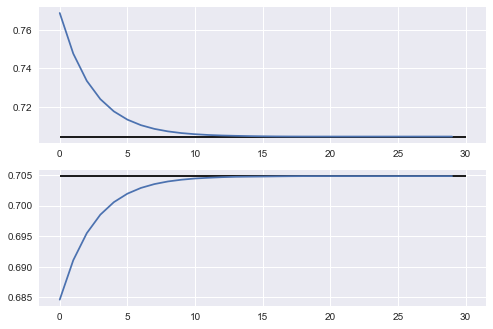

In [35]:
fig, ax = plt.subplots(2,1)
ax[0].plot(kp2)
ax[1].plot(h2)
ax[0].hlines(kss, 0, T)
ax[1].hlines(hss, 0, T)